In [1]:
from rastervision.core.data import(
    RasterioSource,
    ObjectDetectionLabelSource,
    RasterioCRSTransformer,
    GeoJSONVectorSource,
    Scene,
    ClassInferenceTransformer,
    BufferTransformer,
    ClassConfig,
    ObjectDetectionLabels
)
from rastervision.pytorch_learner import(
    ObjectDetectionSlidingWindowGeoDataset,
    # ObjectDetectionRandomWindowGeoDataset
)
import rasterio


2025-01-09 09:25:09:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /opt/data/tmp. Using root: /tmp/tmpwpv2crif
/home/VANDERBILT/zimmejr1/anaconda3/envs/rastervision2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/VANDERBILT/zimmejr1/anaconda3/envs/rastervision2/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.23). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Set Data Variables

In [2]:
import pandas as pd
import os
print(os.getcwd())

IMAGE_DIR = "/mnt/sarl_commons06/Wernke_projects/GeoPACHA/Imagery_Machine_Learning/Analysis_Images"
VECTOR_DIR = '/mnt/sarl_commons06/Wernke_projects/GeoPACHA/Imagery_Machine_Learning/ObjectDetection/FinalData/Ignore_techo'
#Import a scenes csv as a pandas dataframe. This is the labeled scenes from Region01
scene_path='/mnt/sarl_commons06/Wernke_projects/GeoPACHA/Imagery_Machine_Learning/ObjectDetection/FinalData/Ignore_techo/ml_data_2025_01_02/scenes_train.csv'
train_df = pd.read_csv(scene_path)
# train_df = train_df.sample(n=50,random_state=42)

val_df = pd.read_csv('/mnt/sarl_commons06/Wernke_projects/GeoPACHA/Imagery_Machine_Learning/ObjectDetection/FinalData/Ignore_techo/ml_data_2025_01_02/scenes_validation.csv')
# val_df = val_df.sample(n=20,random_state=42)


/home/VANDERBILT/zimmejr1/Documents/Co-DETR_RS


# Read in Data

In [ ]:
from rastervision.pytorch_learner import Classif

In [3]:
# from mmdet.datasets.rastervision_dataset import RasterVisionDataset
from rastervision.core.data import ClassConfig
class_config = ClassConfig(
names=['Arch. Corral', 'Arch. Estructura','Arch. Patio','Mod. Corral','Mod. Estructura'],
# names=['Corral', 'Arch Estructura','Mod. Estructura'],

colors=['lightblue','orange','purple','darkgreen','red'])
# colors=['lightblue','darkgreen','red'])


In [4]:
def approx_num_aoi_chips(aoi_box,chip_size:int) -> int:
    height = aoi_box.ymax-aoi_box.ymin
    width = aoi_box.xmax-aoi_box.xmin
    approx_num_chips = int((height*width)/chip_size**2)
    # print(f"AOI contains approximately {approx_num_chips} chips")
    return approx_num_chips

In [5]:
def _find_patch_size(imagery_path:str)->int:
    with rasterio.open(imagery_path) as image:
        target_crs = rasterio.crs.CRS.from_string('EPSG:3857')
        # print(target_crs)
        img_crs = image.crs
        # print(img_crs)
        transform = image.transform
        width=image.width
        height=image.height
        left=transform[2]
        right = left+transform[0]*width
        bottom=transform[5]+transform[4]*height
        top=transform[5]
        pixel_size = rasterio.warp.calculate_default_transform(src_crs=img_crs,dst_crs=target_crs,width=width,height=height,left=left,right=right,bottom=bottom,top=top)[0][0]
        return pixel_size

In [6]:
def _create_OD_scene(aoi_path:str, image_path:str,label_path:str,class_config:ClassConfig,data_type="training",max_windows=100)-> Scene:
        crs_transformer = RasterioCRSTransformer.from_uri(image_path)

        rasterSource = RasterioSource(
                image_path, #path to the image
                allow_streaming=True, # allow_streaming so we don't have to load the whole image
            ) 
        
        #we used a 256x256 pixel image as standard, and had a max resolution of 0.3m/pixel:
        #Calculate the size of the window at the image's resolution to match this scale
        pixel_size = _find_patch_size(rasterSource.imagery_path)
        patch_ground_size = 256*.3
        #Default patch size
        msize=round(patch_ground_size/pixel_size)

        # Create an AOI source
        aoiSource = GeoJSONVectorSource(
            aoi_path,
            crs_transformer,
        )
    
        # Extract AOI extent
        try:
            myextent=aoiSource.extent
        except:
            raise Exception(f"Problem with {aoi_path}") 

        
        use_sliding_windows = data_type!="training"  or approx_num_aoi_chips(myextent, msize)<=max_windows 
        if use_sliding_windows:
            rasterSource = RasterioSource(
                image_path, #path to the image
                allow_streaming=True, # allow_streaming so we don't have to load the whole image
                bbox=myextent
                ) # Clip the image to the extent of the aoi. This means chip windows will only be created within the bounds of the aoi extent
            #Create the AOI
            aoiSource = GeoJSONVectorSource(
                aoi_path,rasterSource.crs_transformer)         
            

        #If there are labels, import them as GeoJSONVectorSource
        if not os.path.exists(label_path):
            print("No Label geojson exists")
            print(label_path)
            labelSource=None
        if label_path is not None and os.path.exists(label_path):
            #import labels as a GeoJSONVectorSource
            labelVectorSource = GeoJSONVectorSource(
                label_path, # path to the label geojson
                crs_transformer, # convert labels from geographic to pixel coordinates
                vector_transformers=[
                    ClassInferenceTransformer(
                        default_class_id=0
                    )
                ]
            )

        #Convert the label vector to a lable source (format suitable for machine learning)
            try:
                labelSource=ObjectDetectionLabelSource(vector_source=labelVectorSource, #use the above label vectors
                    bbox=rasterSource.bbox, #clip to aoi extent
                    ioa_thresh=0.66
                    )
            except ValueError as e:
                pass
                # labelSource=None
                # print("There was an error. Maybe there are no labels in the AOI?")
                print(aoi_path)
                print(e)

        #Finally create the scene. set the id to "platform" so we can use that information later when we create the dataset
        scene=Scene(
            id=os.path.splitext(os.path.basename(aoi_path))[0],
            raster_source=rasterSource,
            label_source=labelSource,
            aoi_polygons=aoiSource.get_geoms())
        return scene

# Create Scenes

In [7]:
print('Building Scenes')
training_sceneList = []
for index,row in train_df.iterrows():
    aoi_fullpath = os.path.join(VECTOR_DIR,*row['aoi_path'].split("\\"))
    image_fullpath = os.path.join(IMAGE_DIR,*row['image_path'].split("\\"))
    label_fullpath = os.path.join(VECTOR_DIR,*row['label_path'].split("\\"))
    training_sceneList.append(_create_OD_scene(aoi_fullpath,image_fullpath,label_fullpath,class_config=class_config))
        

Building Scenes


# Create Dataset

In [8]:
#CustomODRandomWindowGeoDataset
from rastervision.pytorch_learner import(
    ObjectDetectionRandomWindowGeoDataset
)
import numpy as np
from rastervision.core.box import Box
from rastervision.core.data import ObjectDetectionLabels
import random

import logging
log = logging.getLogger(__name__)
class CustomODRandomWindowGeoDataset(ObjectDetectionRandomWindowGeoDataset):

    def _sample_pos_window(self)->Box:
        """Sample a window containing at least one bounding box.

        This is done by randomly sampling one of the bounding boxes in the
        scene and drawing a random window around it.
        """
        bbox: Box = np.random.choice(self.bboxes)
        box_h, box_w = bbox.size

        # check if it is possible to sample a containing window
        hmax, wmax = self.max_size
        if box_h > hmax or box_w > wmax:
            self.scene.label_source.ioa_thresh=.5
            ymin, xmin, ymax, xmax = [int(coord) for coord in bbox.tuple_format()]
            bbox=Box(ymin,xmin,ymax,xmax)
            windows_over_bbox:list = bbox.get_windows(self.max_size,self.max_size)
            return random.choice(windows_over_bbox)

        # try to sample a window size that is larger than the box's size
        # self.scene.label_source.ioa_thresh=.9
        for _ in range(self.max_sample_attempts):
            h, w = self.sample_window_size()
            if h >= box_h and w >= box_w:
                window = bbox.make_random_box_container(h, w)
                return window
        log.warning('ObjectDetectionRandomWindowGeoDataset: Failed to find '
                    'suitable (h, w) for positive window. '
                    f'Using (hmax, wmax) = ({hmax}, {wmax}) instead.')
        window = bbox.make_random_box_container(hmax, wmax)
        return window
    
    
    # def sample_window(self):
    #     """Sample a window with random size and location within the AOI.

    #     If the scene has AOI polygons, try to find a random window that is
    #     within the AOI. Otherwise, just return the first sampled window.

    #     Raises:
    #         StopIteration: If unable to find a valid window within
    #             self.max_sample_attempts attempts.

    #     Returns:
    #         Box: The sampled window.
    #     """
    #     if not self.has_aoi_polygons:
    #         window = self._generate_window()
    #         return window

    #     for _ in range(self.max_sample_attempts):
    #         window = self._generate_window()
    #         if self.within_aoi:
    #             if Box.within_aoi(window, self.aoi):
    #                 return window
    #         else:
    #             if Box.intersects_aoi(window, self.aoi):
    #                 return window
    #     log.warning('Failed to find valid window within scene AOI in '
    #                         f'{self.max_sample_attempts} attempts, returning an invalid one.')
    #     return window
        
        



    def _generate_window(self):
        """Randomly sample a window with random size and location."""
        h, w = self.sample_window_size()
        x, y = self.sample_window_loc(h, w)
        window = Box(y, x, y + h, x + w)
        return window

In [9]:
def _random_window_dataset(scene:Scene,neg_ratio:float,within_aoi:bool,num_pixels:int,max_windows:int,transform=None)-> CustomODRandomWindowGeoDataset:
    ds = CustomODRandomWindowGeoDataset(
        scene=scene,
        neg_ratio=neg_ratio,
        within_aoi=within_aoi,
        size_lims=(num_pixels,num_pixels+1),
        out_size=224,
        max_windows=max_windows,
        transform = transform
    )
    return ds

In [10]:
import albumentations as A
data_augmentation_transform = A.Compose([
    A.Flip(),
    A.ShiftScaleRotate(),
    # A.OneOf([
    #     # A.HueSaturationValue(hue_shift_limit=10),
    #     # A.RGBShift(),
    #     # A.ToGray(),
    #     # A.ToSepia(),
    #     A.RandomBrightnessContrast(),
    #     A.RandomGamma(),
    # ]),
    # A.CoarseDropout(max_height=32, max_width=32, max_holes=5)
],strict=False)

In [11]:
def _create_OD_dataset(scene:Scene,neg_ratio:float=10,max_windows:int=100,num_pixels:int=256,within_aoi:bool = True,data_type="training",transform=None)-> CustomODRandomWindowGeoDataset|ObjectDetectionSlidingWindowGeoDataset:
    pixel_size = _find_patch_size(scene.raster_source.imagery_path)
    patch_ground_size = num_pixels*.3
    #Default patch size
    msize=round(patch_ground_size/pixel_size)
    mstride=msize
    
    aoi_box = scene.bbox
    use_sliding_windows = data_type!="training"  or approx_num_aoi_chips(aoi_box, msize)<=max_windows 

    
    if not use_sliding_windows:
        labels = scene.label_source.get_labels()
        filtered_labels = labels.filter_by_aoi(scene.aoi_polygons)
        max_windows = int(min(max_windows,len(filtered_labels)*(neg_ratio+1)))
        # print("Finding Random Windows")
        try:
            return _random_window_dataset(scene=scene,neg_ratio=neg_ratio,within_aoi=True,num_pixels=num_pixels,max_windows=max_windows,transform=transform)
        except:
            return _random_window_dataset(scene=scene,neg_ratio=None,within_aoi=True,num_pixels=num_pixels,max_windows=5,transform=transform)


    
    #Create the Dataset
    print('use sliding windows')
    ds = ObjectDetectionSlidingWindowGeoDataset(
        scene=scene, # a scene object as created in step 1
        size=msize, # the dimension of the patch
        stride=mstride, # equal to the patch so there is no overlap and no gaps
        out_size=224, # reshape the patch to be 224
        # pad_direction="both",
        within_aoi=within_aoi,
        # transform=transform
    )
    return(ds)

In [12]:
#Construct a list of datasets from the list of scenes
from torch.utils.data import  ConcatDataset
neg_ratio=.5
within_aoi=True,
max_windows=100
print("Building Datasets")
train_dataset_list = []
for scene_ in training_sceneList:
    train_dataset_list.append(_create_OD_dataset(scene_,neg_ratio=neg_ratio,within_aoi=within_aoi,max_windows=max_windows,transform = data_augmentation_transform))
train_dataset = ConcatDataset(train_dataset_list)
print(f'There are {len(train_dataset)} images in the dataset!')



Building Datasets
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
There are 11361 images in the dataset!


In [13]:
len(train_dataset)

11361

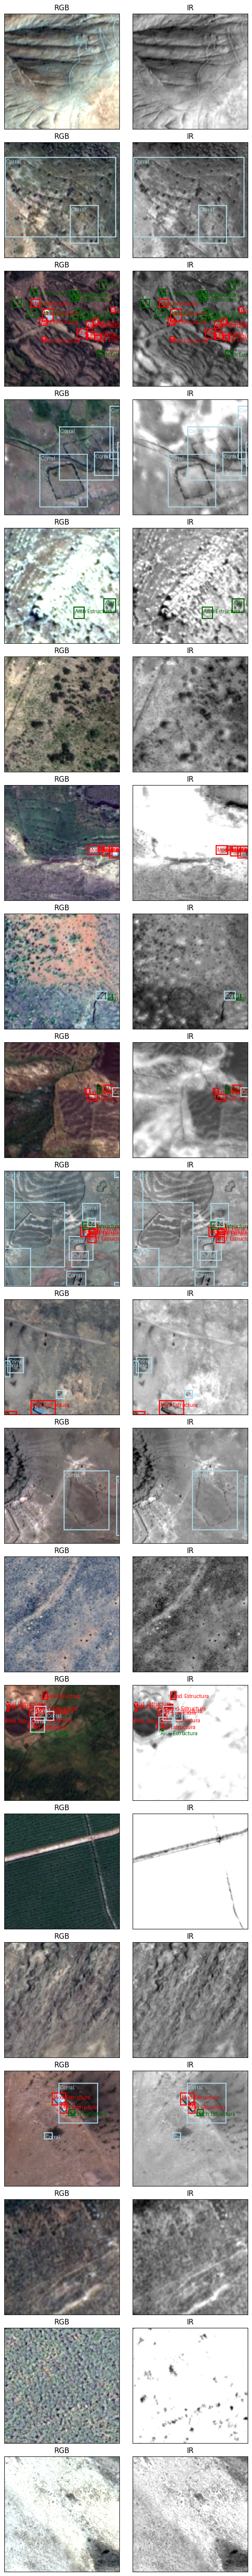

In [14]:
from rastervision.pytorch_learner import (
    ObjectDetectionVisualizer
)
channel_display_groups = {'RGB': (4, 2, 1), 'IR': (6, )}
viz = ObjectDetectionVisualizer(
    class_names=class_config.names, class_colors=class_config.colors, channel_display_groups=channel_display_groups)
x, y = viz.get_batch(train_dataset, 20,shuffle=True)
viz.plot_batch(x, y, show=True)

In [15]:
print('Building Scenes')
validation_sceneList = []
for index,row in val_df.iterrows():
    aoi_fullpath = os.path.join(VECTOR_DIR,*row['aoi_path'].split("\\"))
    image_fullpath = os.path.join(IMAGE_DIR,*row['image_path'].split("\\"))
    label_fullpath = os.path.join(VECTOR_DIR,*row['label_path'].split("\\"))
    validation_sceneList.append(_create_OD_scene(aoi_fullpath,image_fullpath,label_fullpath,class_config=class_config,data_type="validation"))

Building Scenes


In [16]:
#Construct a list of datasets from the list of scenes
from torch.utils.data import  ConcatDataset
neg_ratio=1
within_aoi=True,
max_windows=100
print("Building Datasets")
val_dataset_list = []
for scene_ in validation_sceneList:
    val_dataset_list.append(_create_OD_dataset(scene_,neg_ratio=neg_ratio,within_aoi=within_aoi,max_windows=max_windows,data_type="validation"))
val_dataset = ConcatDataset(val_dataset_list)
print(f'There are {len(val_dataset)} images in the dataset!')

Building Datasets
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
use sliding windows
us

# Define Model

In [17]:
import torch
from rastervision.pytorch_learner import ObjectDetectionModelConfig
from rastervision.pytorch_learner.object_detection_utils import TorchVisionODAdapter
# model = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=True)
model_cfg = ObjectDetectionModelConfig()
model = TorchVisionODAdapter(model_cfg.build_default_model(num_classes=3,in_channels=8,img_sz=224))

In [18]:
from rastervision.pytorch_learner import ObjectDetectionGeoDataConfig

data_cfg = ObjectDetectionGeoDataConfig(
    class_config = class_config,
    num_workers = 25,
)

In [19]:
from rastervision.pytorch_learner import SolverConfig

solver_cfg = SolverConfig(
    batch_sz=48,
    lr=1e-4,
)

In [20]:
import os
os.environ['WORLD_SIZE'] = '1'
os.environ['RASTERVISION_USE_DDP'] = 'NO'

In [21]:
from rastervision.pytorch_learner import ObjectDetectionLearnerConfig, ObjectDetectionLearner
learner_cfg = ObjectDetectionLearnerConfig(data=data_cfg, solver = solver_cfg)
learner = ObjectDetectionLearner(
    cfg = learner_cfg,
    output_dir = "work_dir/Rastervision",
    model = model,
    train_ds = train_dataset,
    valid_ds = val_dataset
)

2025-01-09 09:33:41:rastervision.pytorch_learner.learner: INFO - Building dataloaders


In [22]:
learner.log_data_stats()

2025-01-09 09:33:41:rastervision.pytorch_learner.learner: INFO - train_ds: 11361 items
2025-01-09 09:33:41:rastervision.pytorch_learner.learner: INFO - valid_ds: 569297 items


In [23]:
%load_ext tensorboard

In [24]:
# %tensorboard --bind_all --logdir "/home/VANDERBILT/zimmejr1/Documents/Co-DETR_RS/work_dir/Rastervision/tb-logs" --reload_interval 10

: 

In [26]:
learner.train(epochs=15)

2025-01-09 09:33:41:rastervision.pytorch_learner.learner: INFO - train_ds: 11361 items
2025-01-09 09:33:41:rastervision.pytorch_learner.learner: INFO - valid_ds: 569297 items
2025-01-09 09:33:41:rastervision.pytorch_learner.learner: INFO - Plotting sample training batch.
2025-01-09 09:36:31:rastervision.pytorch_learner.learner: INFO - Plotting sample validation batch.
2025-01-09 09:36:53:rastervision.pytorch_learner.learner: INFO - epoch: 0
Validating: 100%|██████████| 11861/11861 [1:19:19<00:00,  2.49it/s] 
2025-01-09 11:03:47:rastervision.pytorch_learner.object_detection_learner: INFO - None at coco eval


loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
Loading and preparing results...
DONE (t=23.72s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=194.20s).
Accumulating evaluation results...
DONE (t=165.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.162
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.277
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | ma

2025-01-09 11:11:37:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 0,
 'loss_classifier': 0.1673264354467392,
 'loss_box_reg': 0.1384131759405136,
 'loss_objectness': 0.28754979372024536,
 'loss_rpn_box_reg': 0.15162688493728638,
 'train_loss': 0.7449163198471069,
 'train_time': '0:07:34.663076',
 'mAP': np.float64(0.06345721802282284),
 'mAP50': np.float64(0.16175286018732396),
 'valid_time': '1:19:19.621327'}
2025-01-09 11:11:37:rastervision.pytorch_learner.learner: INFO - epoch: 1
Validating: 100%|██████████| 11861/11861 [1:18:01<00:00,  2.53it/s]
2025-01-09 12:33:24:rastervision.pytorch_learner.object_detection_learner: INFO - None at coco eval


loading annotations into memory...
Done (t=0.70s)
creating index...
index created!
Loading and preparing results...
DONE (t=21.57s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=173.68s).
Accumulating evaluation results...
DONE (t=118.88s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.128
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.035
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | ma

2025-01-09 12:39:56:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 1,
 'loss_classifier': 0.13277970254421234,
 'loss_box_reg': 0.17500141263008118,
 'loss_objectness': 0.15114322304725647,
 'loss_rpn_box_reg': 0.12796565890312195,
 'train_loss': 0.5868900418281555,
 'train_time': '0:03:44.640141',
 'mAP': np.float64(0.10240644040413084),
 'mAP50': np.float64(0.2355993622279053),
 'valid_time': '1:18:01.526016'}
2025-01-09 12:39:56:rastervision.pytorch_learner.learner: INFO - epoch: 2
Validating:  55%|█████▍    | 6479/11861 [44:08<35:25,  2.53it/s]  

In [26]:

# try_predict_sceneList = []
# for index,row in try_predict_df.iterrows():
#     aoi_fullpath = os.path.join(VECTOR_DIR,*row['aoi_path'].split("\\"))
#     image_fullpath = os.path.join(IMAGE_DIR,*row['image_path'].split("\\"))
#     label_fullpath = os.path.join(VECTOR_DIR,*row['label_path'].split("\\"))
#     try_predict_sceneList.append(_create_OD_scene(aoi_path=aoi_fullpath,image_path=image_fullpath,label_path=label_fullpath,class_config=class_config))
        

In [27]:
# try_predict_df.head()

In [ ]:
VALID_IMAGE_POLY_DIR = "/mnt/sarl_commons06/Wernke_projects/GeoPACHA/Imagery_Machine_Learning/Shape_overview/NEH_Valid_Regions"
from torch.utils.data import  ConcatDataset
# try_predict_df = val_df.sample(n=5,random_state=42)
try_predict_df = val_df

print("Building Datasets")
try_predict_datasetList = []
for index,row in try_predict_df.iterrows():
    image_fullpath = os.path.join(IMAGE_DIR,*row['image_path'].split("\\"))
    label_fullpath = os.path.join(VECTOR_DIR,*row['label_path'].split("\\"))
    # aoi_fullpath = os.path.join(VALID_IMAGE_POLY_DIR,f"ImageID_{row['image_id']}.geojson")
    aoi_fullpath = os.path.join(VECTOR_DIR,*row['aoi_path'].split("\\"))

    pixel_size = _find_patch_size(image_fullpath)
    patch_ground_size = 256*.3
    #Default patch size
    msize=round(patch_ground_size/pixel_size)    
    try_predict_datasetList.append(ObjectDetectionSlidingWindowGeoDataset.from_uris(image_uri=image_fullpath,label_vector_uri=label_fullpath,aoi_uri = aoi_fullpath,class_config=class_config,size=msize,stride=int(msize*.75)))

In [ ]:
len(try_predict_datasetList)

In [29]:
# ds = val_dataset_list[1]
# predictions = learner.predict_dataset(
#     ds,
#     raw_out=True,
#     numpy_out=True,
#     predict_kw=dict(out_shape=(224, 224)),
#     progress_bar=True)


In [30]:
# pred_labels = ObjectDetectionLabels.from_predictions(
#     ds.windows,
#     predictions)

In [31]:
# import torch
# import matplotlib.pyplot as plt

# # Assuming you have your model defined as 'model'
# for name, param in learner.model.named_parameters():
#     if param.requires_grad:
#         plt.hist(param.data.view(-1).cpu().numpy(), bins=50)
#         plt.title(name)
#         plt.show()

In [32]:
# ds.scene.raster_source.bbox


In [33]:
# len(pruned_labels)

In [34]:
# len(ds.windows[0:int(len(predictions)/10)])

In [ ]:
from rastervision.core.data import ObjectDetectionLabels

for ds in try_predict_datasetList:
    num_split=15
    print(len(ds))
    predictions = learner.predict_dataset(
            ds,
            raw_out=True,
            numpy_out=True,
            dataloader_kw = {'num_workers':30,'batch_size':48},
            # predict_kw=dict(out_shape=(224, 224)),
            progress_bar=True)
    # for split in range(1,num_split+1):
        
    #     num_windows = len(ds.windows)
    #     windows_per_split=int(num_windows/num_split)
    #     lower_split = (split-1)*windows_per_split
    #     upper_split = split*windows_per_split
    #     if split == num_split:
    #         upper_split=num_windows
        
    #     # print(lower_split)
    #     # print(upper_split)

    pred_labels = ObjectDetectionLabels.from_predictions(
        ds.windows,
        predictions,
        )
        # if split==1:
        #     merge_labels = pred_labels
        # else:
        #     merge_labels = merge_labels.concatenate(merge_labels,pred_labels)
        # print(f"Finished split {split}!")

    filename_without_ext, _ = os.path.splitext(os.path.basename(ds.scene.raster_source.imagery_path))    
    pruned_labels = pred_labels.prune_duplicates(pred_labels,score_thresh=0.5,merge_thresh=.3)
    pruned_labels.save(uri=f"{filename_without_ext}_predict__validation.geojson",class_config=class_config,crs_transformer=ds.scene.raster_source.crs_transformer)


    
    

In [36]:
# junlin_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
# teacher_checkpoint = pretrained_weights # path to .pth
# pretrained_dict = torch.load(teacher_checkpoint)
# checkpoint_key = 'teacher'
# new_state_dict = {}
# for k, v in pretrained_dict[checkpoint_key].items():
#     if 'dino_head' in k:
#         print(f'{k} not used')    
#     elif 'ibot_head' in k:
#         print(f'{k} not used')
#     else:
#         new_key = k.replace('backbone.', '')
#         new_state_dict[new_key] = v
# #change shape of pos_embed, shape depending on vits or vitg, or  vitl
# pos_embed = nn.Parameter(torch.zeros(1, 257, 1024))
# junlin_model.pos_embed = pos_embed# change shape of patch embed (it was not all correct)
# # patch_embed_weight = nn.Parameter(torch.zeros(1024, 8, 14, 14))
# # model.patch_embed.proj.weight = patch_embed_weight########################################################################
# new_patch_embed = junlin_model.patch_embed
# new_patch_embed.proj = nn.Conv2d(
#     in_channels=8,  # Updated for 8 input bands
#     out_channels=new_patch_embed.proj.out_channels,
#     kernel_size=new_patch_embed.proj.kernel_size,
#     stride=new_patch_embed.proj.stride,
#     padding=new_patch_embed.proj.padding,
#     # bias=new_patch_embed.proj.bias,
# )
# # Replace the old PatchEmbed with the updated one
# junlin_model.patch_embed = new_patch_embed# load state dict
# junlin_model.load_state_dict(new_state_dict, strict=True)